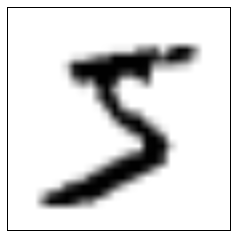

In [1]:
import base64
import json
import numpy as np
from pyspark.mllib.clustering import KMeans
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline

# load data
def parse(x):
   digit = json.loads(x)
   array = np.fromstring(base64.b64decode(digit["data"]),
     dtype = np.ubyte)
   return (digit["label"], array)
digits = sc.textFile("digits.base64.json").map(parse)

# show an image
images = digits.take(1)
for i in range(1):
    image = images[i][1]
    image = image.astype(float)/256
    plt.figure(i)
    fig = plt.imshow(image.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [2]:
# initialize training and dev partitions
n = digits.count()
digits_train, digits_dev = digits.randomSplit([3 / 4, 1 / 4], 100)
print 'training and dev size: %d and %d.' % (digits_train.count(), digits_dev.count())

training and dev size: 44964 and 15036.


In [3]:
K = 10 # number of clusters
clusters = KMeans.train(digits_train.map(lambda x: x[1]), K, maxIterations = 50, runs = 10, initializationMode = "random")

In [4]:
# associate clusters
def asscLabels(cl):
    labs = []
    for i in range(len(cl.centers)): # for cluster center i
        center = cl.centers[i]
        risks = [] # store empirical risks
        for j in range(10): # compute distance from each digit j
            filtered = digits_train.filter(lambda x: x[0] == j)
            r = filtered.map(lambda x: sum((x[1] - center) ** 2)).reduce(lambda x, y: x + y) / filtered.count()
            risks.append(r)
        val, lab = min((val, idx) for (idx, val) in enumerate(risks)) # find minimum risk and its label
        labs.append(lab)
    return labs

In [5]:
clusterLabels = asscLabels(clusters)
clusterLabels

[2, 3, 9, 1, 6, 0, 0, 7, 1, 8]

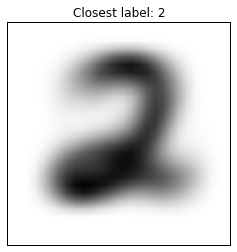

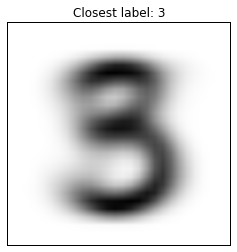

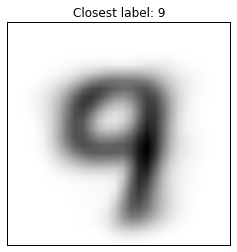

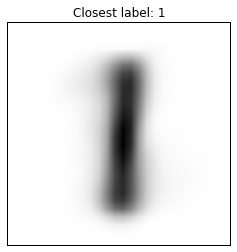

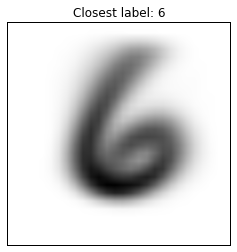

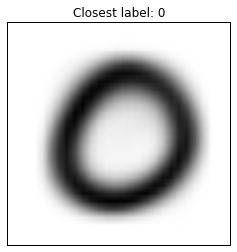

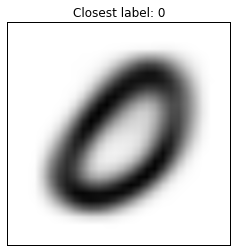

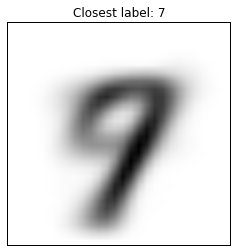

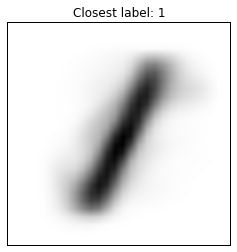

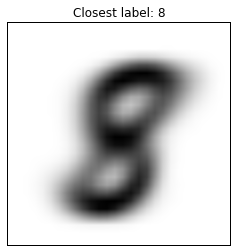

In [6]:
# visualize cluster centers and compare with closest label
for i in range(10):
    image = clusters.centers[i]
    image = image.astype(float)/256
    plt.figure(i)
    fig = plt.imshow(image.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title('Closest label: %d' % clusterLabels[i])

In [7]:
errorRate = 1 - digits_dev.map(lambda x: clusterLabels[clusters.predict(x[1])] == x[0]).mean()
print 'Error rate for %d clusters: %.2f%%' % (K, errorRate * 100)

Error rate for 10 clusters: 41.19%


In [9]:
# Compute test error for a range of K
rates = []
for k in range(5, 26):
    #print 'Computing for K = %d...' % k
    clusters = KMeans.train(digits_train.map(lambda x: x[1]), k, maxIterations = 50, runs = 5, initializationMode = "random")
    clusterLabels = asscLabels(clusters)
    rates.append(1 - digits_dev.map(lambda x: clusterLabels[clusters.predict(x[1])] == x[0]).mean())
    #print 'Error rate for K = %d: %.2f%%' % (k, rates[-1] * 100)

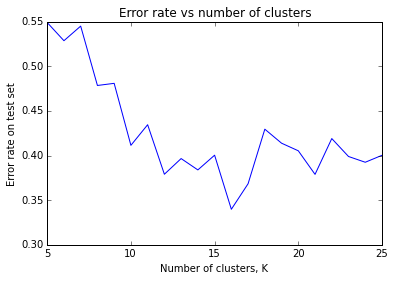

In [15]:
plt.plot(range(5, 26), rates)
plt.xlabel('Number of clusters, K')
plt.ylabel('Error rate on test set')
plt.title('Error rate vs number of clusters')

In [ ]:
# We now turn to supervised learning
